# Gradient damage as phase-field models of brittle fracture: dolfinx example

*Authors: Jack Hale, Corrado Maurini, 2021*

In this notebook we implement a numerical solution of the quasi-static evolution problem for gradient damage models, and show how they can be used to solve brittle fracture problems.

Denoting by $u$ the displacement field (vector valued) and by $\alpha$ the scalar damage field we consider the energy functional

$$
\mathcal{E}_{\ell}(u, \alpha)=
\dfrac{1}{2}\int_{\Omega} a({\alpha})
A_0\,\epsilon(u)\cdot\epsilon(u)\,dx
+
 \,
\dfrac{G_c}{c_w} \int_{\Omega}\left(
\dfrac{w(\alpha)}{\ell}+
{\ell}\,\nabla {\alpha}\cdot\nabla{\alpha}\right)dx,
$$

where $\epsilon(u)$ is the strain tensor, $\sigma_0=A_0\,\epsilon=\lambda \mathrm{tr}\epsilon+2\mu \epsilon$ the stress of the undamaged material, $a({\alpha})$  the stiffness modulation function though the damage field, $w_1\,w(\alpha)$ the energy dissipation in an homogeouns process and $\ell$ the internal length.

In the following we will solve, at each time step $t_i$ the minimization problem 

$$
\min\mathcal{E}_{\ell}(u, \alpha),\quad u\in\mathcal{C}_i, \alpha\in \mathcal{D}_i,
$$

where $\mathcal{C}_i$ is the space of kinematically admissible displacement at 
time $t_i$ and $\mathcal{D}_i$ the admissible damage fields, that should respect the irreversibility conditions 
$\alpha\geq\alpha_{i-1}$. 

Here we will
 * Discretize the problme using $P_1$ finite elements for the displacement and the damage field
 * Use alternate minimization to solve the minimization problem at each time step
 * Use PETSc solver to solve linear problems and variational inequality at discrete level
 

We will consider here the specific problem of the **traction of a two-dimensional bar in plane-stress**, where
$
\Omega =[0,L]\times[0,H]
$ and the loading is given by 
under imposed end-displacement $u=(t,0)$ in $x=L$, the left-end being clamped : $u=(0,0)$ in $x=0$. 

You can find further informations about this model here:
- Marigo, J.-J., Maurini, C., & Pham, K. (2016). An overview of the modelling of fracture by gradient damage models. Meccanica, 1–22. https://doi.org/10.1007/s11012-016-0538-4 

## Preamble 

Here we import the required Python modules and set few parameters.

The FEniCS container does not have the `sympy` module by default so we install it using pip.

In [1]:
!pip3 install sympy

In [54]:
import matplotlib.pyplot as plt
import numpy as np

import dolfinx
import ufl

from dolfinx import cpp, fem, mesh, plot, nls
from mpi4py import MPI
from petsc4py import PETSc

import pyvista
import warnings

warnings.simplefilter("ignore")
from pyvista.utilities.xvfb import start_xvfb
start_xvfb(wait=0.5)

import sys
sys.path.append("../python/")
import snes_problem
from snes_problem import SNESProblem

from plots import plot_damage_state

## Mesh 

We define here the mesh and the indicators for the boundary conditions. The function `generate_mesh` uses `gmsh` (https://gmsh.info/).

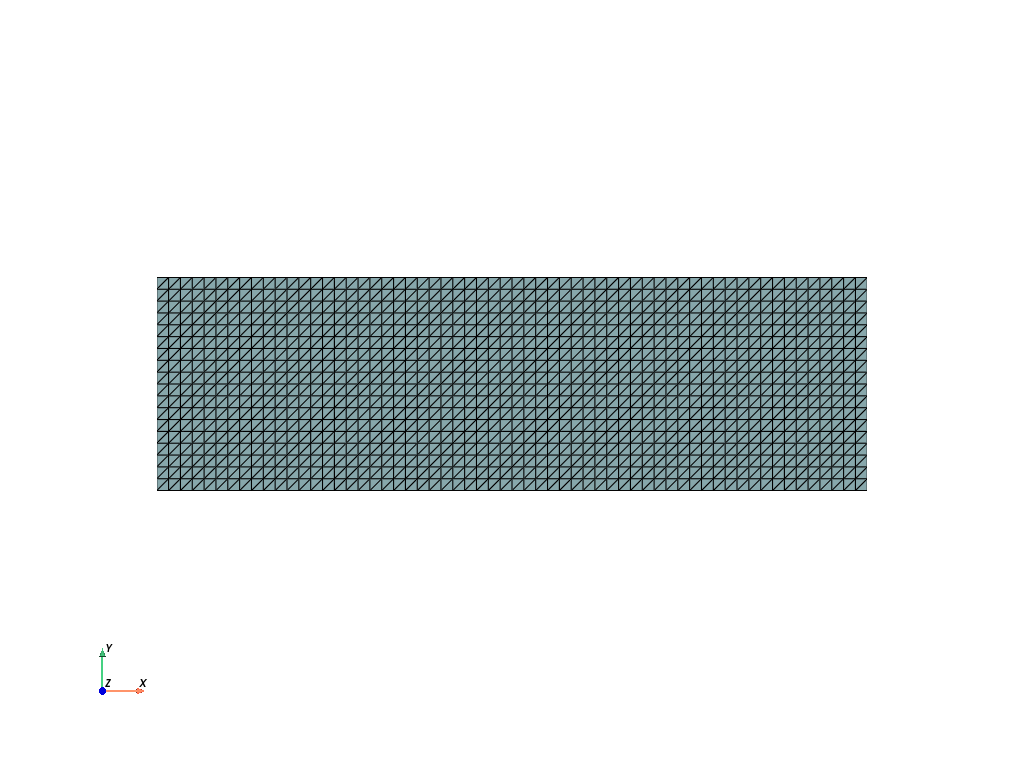

In [43]:
L = 1.; H = 0.3;
ell_ = 0.1
cell_size = ell_/6;

nx = int(L/cell_size)
ny = int(H/cell_size)

domain = mesh.create_rectangle(MPI.COMM_WORLD, ((0, 0), (L, H)), [nx, ny], cell_type=mesh.CellType.triangle)


ndim = domain.geometry.dim


pyvista.OFF_SCREEN 
topology, cell_types, x = plot.create_vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, domain.geometry.x)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True, show_scalar_bar=True)
plotter.view_xy()
plotter.add_axes()
plotter.set_scale(5,5)
#plotter.reset_camera(render=True, bounds=(-L/2, L/2, -H/2, H/2, 0, 0))
if not pyvista.OFF_SCREEN:
    plotter.show()

from pathlib import Path
Path("output").mkdir(parents=True, exist_ok=True)
figure = plotter.screenshot("output/mesh.png")



## Setting the stage

Setting the finite element space, the state vector, test/trial functions and measures.

We use $P_1$ finite element (triangle with linear Lagrange polynomial as shape functions and nodal values as dofs) for both displacement and damage. 

In [44]:
element_u = ufl.VectorElement('Lagrange', domain.ufl_cell(), degree=1, dim=2)
V_u = fem.functionspace(domain, element_u)

element_alpha = ufl.FiniteElement('Lagrange', domain.ufl_cell(), degree=1)
V_alpha = fem.functionspace(domain, element_alpha)

# Define the state
u = fem.Function(V_u, name="Displacement")
alpha = fem.Function(V_alpha, name="Damage")

state = {"u": u, "alpha": alpha}

# need upper/lower bound for the damage field
alpha_lb = fem.Function(V_alpha, name="Lower bound")
alpha_ub = fem.Function(V_alpha, name="Upper bound")

# Measures
dx = ufl.Measure("dx",domain=domain)
ds = ufl.Measure("ds",domain=domain)

### Boundary conditions
We impose the boundary conditions on the displacement and the damage field. 

In [45]:
def bottom(x):
    return np.isclose(x[1], 0.0)

def right(x):
    return np.isclose(x[0], L)

def top(x):
    return np.isclose(x[1], H)

def left(x):
    return np.isclose(x[0], 0.0)

blocked_dofs_left_u = fem.locate_dofs_geometrical(V_u.sub(0).collapse()[0], left)
blocked_dofs_right_u = fem.locate_dofs_geometrical(V_u.sub(0).collapse()[0], right)
blocked_dofs_bottom_u = fem.locate_dofs_geometrical(V_u.sub(1).collapse()[0], bottom)
blocked_dofs_left_alpha = fem.locate_dofs_geometrical(V_alpha, left)
blocked_dofs_right_alpha = fem.locate_dofs_geometrical(V_alpha, right)

zero_u = fem.Function(V_u.sub(0).collapse()[0])
with zero_u.vector.localForm() as bc_local:
    bc_local.set(0.0)

nonzero_u = fem.Function(V_u.sub(0).collapse()[0])
with nonzero_u.vector.localForm() as bc_local:
    bc_local.set(1.0)
    
one_alpha = fem.Function(V_alpha)
with one_alpha.vector.localForm() as bc_local:
    bc_local.set(1.0)
                 
zero_alpha = fem.Function(V_alpha)
with zero_alpha.vector.localForm() as bc_local:
    bc_local.set(0.0)


bc_u0 = fem.dirichletbc(PETSc.ScalarType(0), blocked_dofs_left_u, V=V_u.sub(0))
bc_u1 = fem.dirichletbc(PETSc.ScalarType(0), blocked_dofs_right_u, V=V_u.sub(0))
bc_u2 = fem.dirichletbc(PETSc.ScalarType(0), blocked_dofs_bottom_u, V_u.sub(1))

bc_alpha0 = fem.dirichletbc(PETSc.ScalarType(0), blocked_dofs_left_alpha, V=V_u.sub(0))
bc_alpha1 = fem.dirichletbc(PETSc.ScalarType(0), blocked_dofs_right_alpha, V=V_u.sub(0))

bcs_u = [bc_u0, bc_u1, bc_u2]
bcs_alpha = [bc_alpha0, bc_alpha1]

# setting the upper bound to 0 where BCs are applied
alpha_ub.interpolate(one_alpha)
fem.set_bc(alpha_ub.vector, bcs_alpha)


## Variational formulation of the problem

### Constitutive functions

We define here the constitutive functions and the related parameters. 
These functions will be used to define the energy. You can try to change them, the code is sufficiently generic to allows for a wide class of function $w$ and $a$.

**Exercice:** Show by dimensional analysis that varying $G_c$ and $E$ is equivalent to a rescaling of the displacement by a factor 

$$
u_0 = \sqrt{\frac{G_c L}{E}}
$$

We can then choose these constants freely in the numerical work and simply rescale the displacement to match the material data of a specific brittle material. 
The *real* material parameters (in the sense that they are those that affect the results) are   
- the Poisson ratio $\nu$ and 
- the ratio $\ell/L$ between internal length $\ell$ and the domain size $L$. 

In [46]:
E, nu = fem.Constant(domain, 100.0), fem.Constant(domain, 0.3)
Gc = fem.Constant(domain, 1.0)
ell = fem.Constant(domain, ell_)

def w(alpha):
    """Dissipated energy function as a function of the damage """
    return alpha

def a(alpha, k_ell=1.e-6):
    """Stiffness modulation as a function of the damage """
    return (1 - alpha) ** 2 + k_ell

def eps(u):
    """Strain tensor as a function of the displacement"""
    return ufl.sym(ufl.grad(u))

def sigma_0(u):
    """Stress tensor of the undamaged material as a function of the displacement"""
    mu    = E / (2.0 * (1.0 + nu))
    lmbda = E * nu / (1.0 - nu ** 2)
    return 2.0 * mu * eps(u) + lmbda * ufl.tr(eps(u)) * ufl.Identity(ndim)

def sigma(u,alpha):
    """Stress tensor of the damaged material as a function of the displacement and the damage"""
    return a(alpha) * sigma_0(u)


**Exercise:** Show that 
1. One can relate the dissipation constant $w_1$ to the energy dissipated in a smeared representation of a crack through the following relation:
\begin{equation}
{G_c}={c_w}\,w_1\ell,\qquad c_w =4\int_0^1\sqrt{w(\alpha)}d\alpha
\end{equation}
2. The half-width of a localisation zone is given by:
$$
D =  c_{1/w} \ell,\qquad c_{1/w}=\int_0^1 \frac{1}{\sqrt{w(\alpha)}}d\alpha
$$
3. The elastic limit of the material is:
$$
\sigma_c = \sqrt{w_1\,E_0}\sqrt{\dfrac{2w'(0)}{s'(0)}}= \sqrt{\dfrac{G_cE_0}{\ell c_w}}
\sqrt{\dfrac{2w'(0)}{s'(0)}}
$$
*Hint:* Calculate the damage profile and the energy of a localised solution with vanishing stress in a 1d traction problem

For the function above we get (we perform the integral with `sympy`).

In [47]:
import sympy 
z = sympy.Symbol("z")
c_w = 4*sympy.integrate(sympy.sqrt(w(z)),(z,0,1))
print("c_w = ",c_w)

c_1w = sympy.integrate(sympy.sqrt(1/w(z)),(z,0,1))
print("c_1/w = ",c_1w)

tmp = 2*(sympy.diff(w(z),z)/sympy.diff(1/a(z),z)).subs({"z":0})
sigma_c = sympy.sqrt(tmp * Gc.value * E.value / (c_w * ell.value))
print("sigma_c = %2.3f"%sigma_c)

eps_c = float(sigma_c/E.value)
print("eps_c = %2.3f"%eps_c)

c_w =  8/3
c_1/w =  2
sigma_c = 19.365
eps_c = 0.194


### Energy functional and its derivatives

We use the `UFL` 
 component of FEniCS to define the energy functional.
Directional derivatives of the energy are computed using symbolic computation functionalities of `UFL`, see http://fenics-ufl.readthedocs.io/en/latest/

In [48]:
# f = fem.Constant(domain, PETSc.Vec([1, 1]))
x = ufl.SpatialCoordinate(domain)
f = ufl.FacetNormal(x) * 0
elastic_energy = 0.5 * ufl.inner(sigma(u, alpha), eps(u)) * dx 
dissipated_energy = Gc / float(c_w) * (w(alpha) / ell + ell * ufl.dot(ufl.grad(alpha), ufl.grad(alpha))) * dx
external_work = ufl.dot(f, u) * dx 
total_energy = elastic_energy + dissipated_energy - external_work

(2,) (0,) (2,)


## Solvers

### Displacement problem
The $u$-problem at fixed $\alpha$ is a linear problem corresponding with linear elasticity. We solve it with a standard linear solver. We use automatic differention to get the first derivative of the energy. We use a direct solve to solve the linear system, but you can also easily set iterative solvers and preconditioners when solving large problem in parallel.

In [10]:
E_u = ufl.derivative(total_energy, u, ufl.TestFunction(V_u))
E_du = ufl.replace(E_u,{u: ufl.TrialFunction(V_u)})
options = {
    "ksp_type": "preonly",
    "pc_type": "lu"
}
problem_u = fem.LinearProblem(a=ufl.lhs(E_du), L=ufl.rhs(E_du), bcs=bcs_u, u=u,
                                      petsc_options=options)

problem_u.solve()

Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2)), 3)

We test below the solution of the elasticity problem

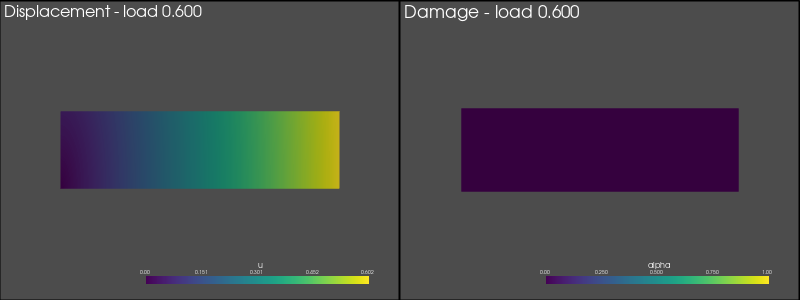

In [11]:
load = .6
with nonzero_u.vector.localForm() as bc_local:
        bc_local.set(load) 
        
problem_u.solve()

plot_damage_state(state,load=load)

### Damage problem with bound-constraints

The $\alpha$-problem at fixed $u$ is a variational inequality, because of the irreversibility constraint. We solve it using a specific solver for bound-constrained provided by `PETSC`, called `SNESVI`. To this end we define with a specific syntax a class defining the problem, and the lower (`lb`) and upper (`ub`) bounds. 

See the [../03-variational-inequalities/VI.ipynb](../03-variational-inequalities/VI.ipynb) notebook for further details

We now set up the PETSc solver using petsc4py (https://www.mcs.anl.gov/petsc/petsc-current/docs/manualpages/SNES/SNESVINEWTONRSLS.html)

In [12]:

E_alpha = ufl.derivative(total_energy, alpha, ufl.TestFunction(V_alpha))
E_alpha_alpha = ufl.derivative(E_alpha, alpha, ufl.TrialFunction(V_alpha))

damage_problem = SNESProblem(E_alpha, E_alpha_alpha, alpha, bcs_alpha)

b = cpp.la.create_vector(V_alpha.dofmap.index_map, V_alpha.dofmap.index_map_bs)
J = fem.create_matrix(damage_problem.a)

# Create Newton solver and solve
solver_alpha_snes = PETSc.SNES().create()
solver_alpha_snes.setType("vinewtonrsls")
solver_alpha_snes.setFunction(damage_problem.F, b)
solver_alpha_snes.setJacobian(damage_problem.J, J)
solver_alpha_snes.setTolerances(rtol=1.0e-9, max_it=50)
solver_alpha_snes.getKSP().setType("preonly")
solver_alpha_snes.getKSP().setTolerances(rtol=1.0e-9)
solver_alpha_snes.getKSP().getPC().setType("lu")

# We set the bound (Note: they are passed as reference and not as values)
solver_alpha_snes.setVariableBounds(alpha_lb.vector,alpha_ub.vector)

Let us known test the damage solver

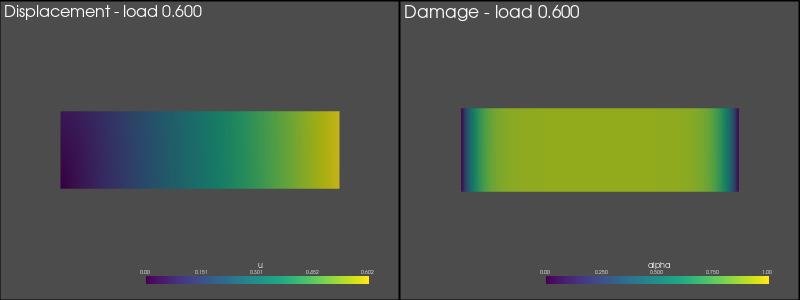

In [13]:
solver_alpha_snes.solve(None, alpha.vector)
plot_damage_state(state,load=load)

### The static problem: solution with the alternate minimization algorithm

We solve the nonlinear problem in $(u,\alpha)$ at each time-step by a fixed-point algorithm consisting in alternate minimization with respect to $u$ at fixed $\alpha$ and viceversa, *i.e.* we solve till convergence the $u$- and the $\alpha$-problems above.

The main idea is to iterate as following solution of displacement and damage subproblem at fixed loading

iteration 0


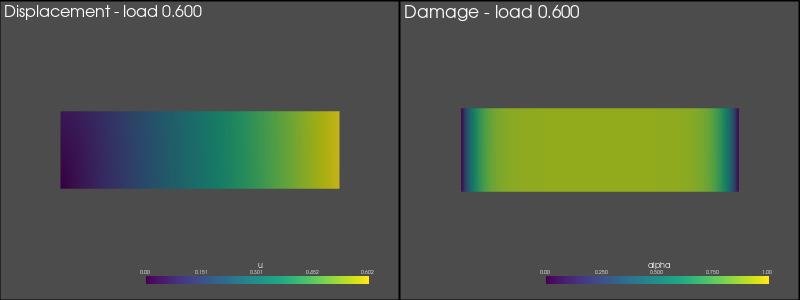

iteration 1


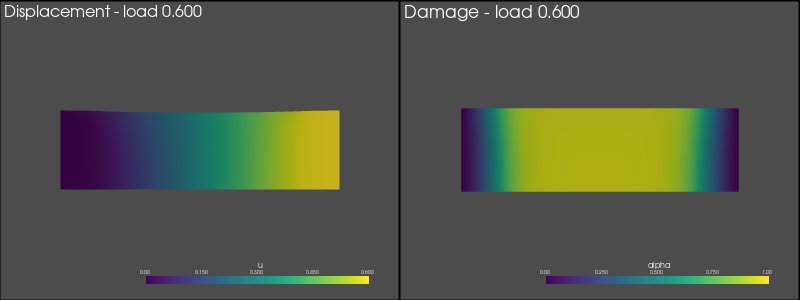

iteration 2


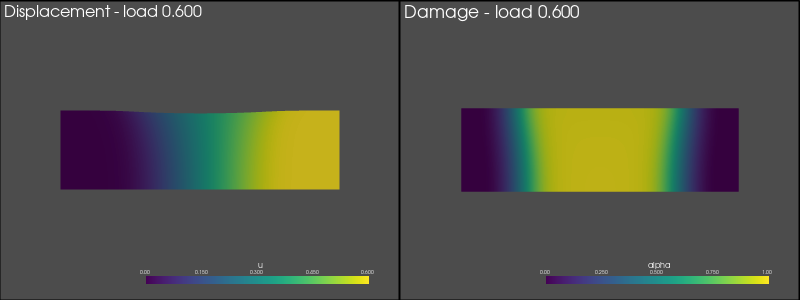

iteration 3


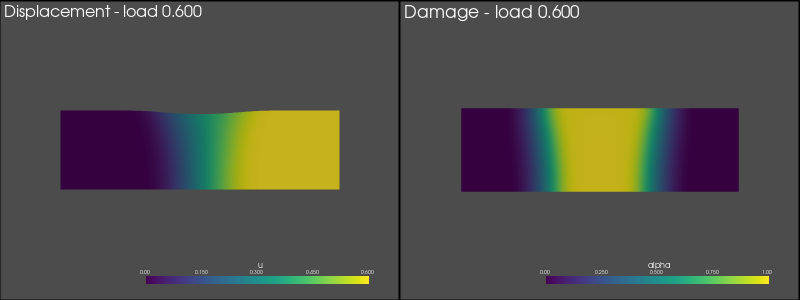

iteration 4


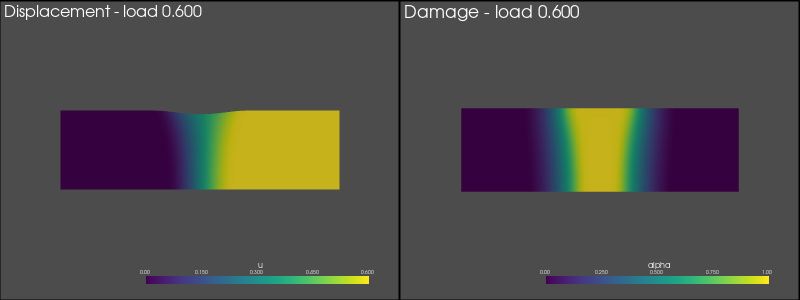

iteration 5


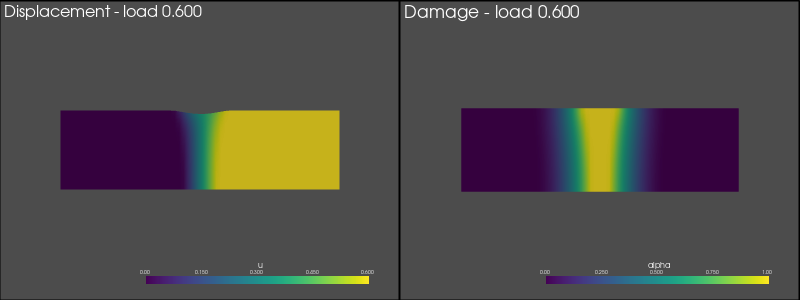

iteration 6


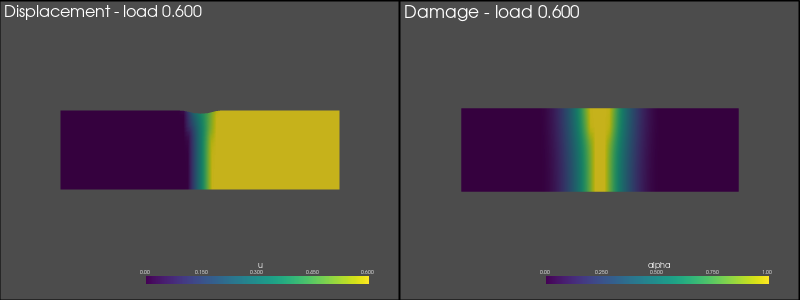

iteration 7


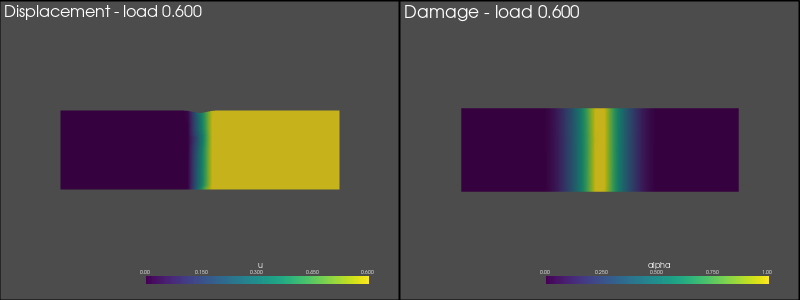

iteration 8


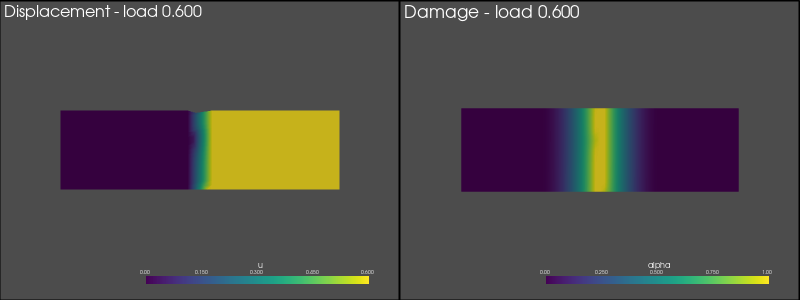

iteration 9


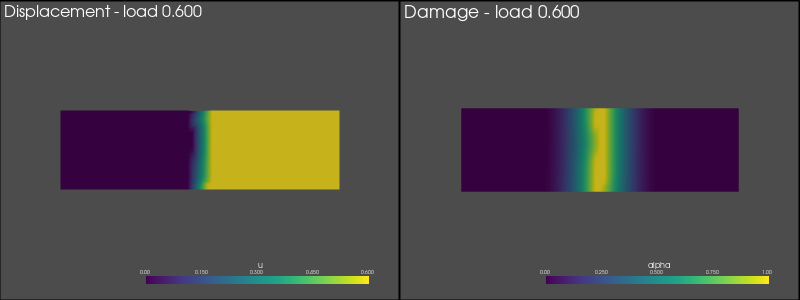

In [14]:
with alpha.vector.localForm() as alpha_local:
    alpha_local.set(0)

for i in range(10):
    print(f"iteration {i}")
    problem_u.solve()
    solver_alpha_snes.solve(None, alpha.vector)
    plot_damage_state(state,load)

We need to add a convergence condition for the fixed point algorithm.
We define it the following function

In [17]:
alt_min_parameters = {"atol": 1.e-8, "max_iter": 100}

def simple_monitor(state, iteration, error_L2):
    #if MPI.comm_world.rank == 0:
    print(f"Iteration: {iteration:3d}, Error: {error_L2:3.4e}")
    
def alternate_minimization(state,parameters=alt_min_parameters,monitor=None):
    
    u = state["u"]
    alpha = state["alpha"]
    
    alpha_old = dolfinx.Function(alpha.function_space)
    alpha.vector.copy(alpha_old.vector)
    
    for iteration in range(parameters["max_iter"]):
                              
        # solve displacement
        problem_u.solve()
        
        # solve damage
        solver_alpha_snes.solve(None, alpha.vector)
        
        # check error and update
        L2_error = ufl.inner(alpha - alpha_old, alpha - alpha_old) * dx
        error_L2 = np.sqrt(dolfinx.fem.assemble_scalar(L2_error))
        alpha.vector.copy(alpha_old.vector)
        
        if monitor is not None:
            monitor(state, iteration, error_L2)
                                 
        if error_L2 <= parameters["atol"]:
            break
    else:
        pass #raise RuntimeError(f"Could not converge after {iteration:3d} iteration, error {error_L2:3.4e}") 
    
    return (error_L2, iteration)

We can test it by solving the problem at fixed problem. We need to reset to zeror the damage field to start

Iteration:   0, Error: 4.5577e-01
Iteration:   1, Error: 1.1046e-01
Iteration:   2, Error: 1.4358e-01
Iteration:   3, Error: 1.3343e-01
Iteration:   4, Error: 1.0460e-01
Iteration:   5, Error: 6.6663e-02
Iteration:   6, Error: 3.7487e-02
Iteration:   7, Error: 1.5170e-02
Iteration:   8, Error: 2.0475e-03
Iteration:   9, Error: 5.3557e-03
Iteration:  10, Error: 6.6910e-03
Iteration:  11, Error: 6.4167e-03
Iteration:  12, Error: 1.1111e-03
Iteration:  13, Error: 6.2454e-04
Iteration:  14, Error: 1.4914e-06
Iteration:  15, Error: 4.2970e-09


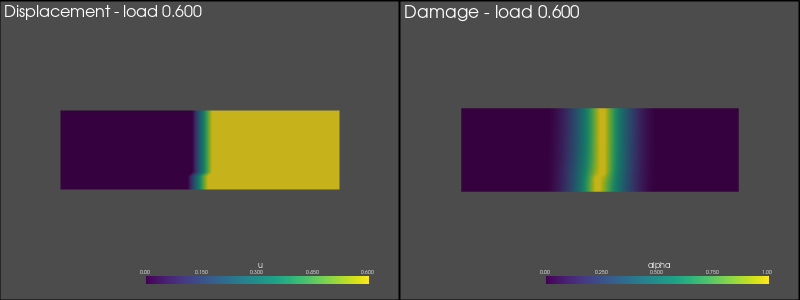

In [18]:
with alpha.vector.localForm() as alpha_local:
    alpha_local.set(0)
    
alternate_minimization(state,parameters=alt_min_parameters,monitor=simple_monitor)
plot_damage_state(state, load=load)

## Time-stepping: solving a quasi-static problem

In [49]:
def postprocessing(state, iteration, error_L2):
    
    # Save number of iterations for the time step
    iterations[i_t] = np.array([t,i_t])
    
    # Calculate the energies
    elastic_energy_value = fem.assemble_scalar(elastic_energy)
    surface_energy_value = fem.assemble_scalar(dissipated_energy)
    energies[i_t] = np.array([t, elastic_energy_value, surface_energy_value, elastic_energy_value + surface_energy_value])
    
    simple_monitor(state, iteration, error_L2)

In [50]:
load0 = float(eps_c) * L # reference value for the loading (imposed displacement)
loads = load0 * np.linspace(0, 1.5, 20)

energies = np.zeros((len(loads),4))
iterations = np.zeros((len(loads),2))

alt_min_parameters = {"atol": 1.e-6,"max_iter": 100}

with alpha.vector.localForm() as alpha_local:
    alpha_local.set(0)

for i_t, t in enumerate(loads):
    with nonzero_u.vector.localForm() as bc_local:
        bc_local.set(t) 
        
    # update the lower bound
    alpha.vector.copy(alpha_lb.vector)    
    print(f"-- Solving for t = {t:3.2f} --")
    alternate_minimization(state, parameters=alt_min_parameters, monitor=postprocessing)
    plot_damage_state(state)

-- Solving for t = 0.00 --


NameError: name 'alternate_minimization' is not defined

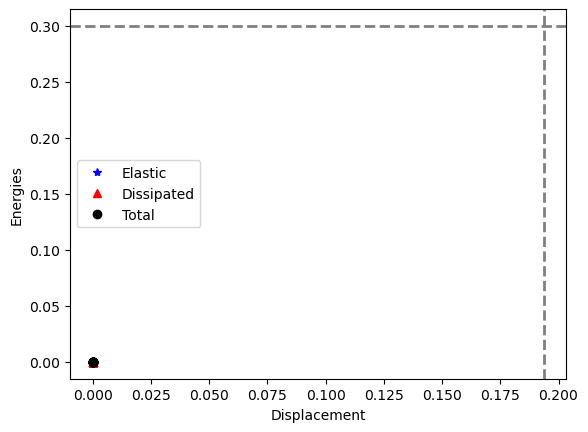

In [51]:
p1, = plt.plot(energies[:,0], energies[:,1],'b*',linewidth=2)
p2, = plt.plot(energies[:,0], energies[:,2],'r^',linewidth=2)
p3, = plt.plot(energies[:,0], energies[:,3],'ko',linewidth=2)
plt.legend([p1, p2, p3], ["Elastic","Dissipated","Total"])
plt.xlabel('Displacement')
plt.ylabel('Energies')

plt.axvline(x=eps_c*L, color='grey',linestyle='--', linewidth=2)
plt.axhline(y=H, color='grey', linestyle='--', linewidth=2)

plt.savefig(f"output/energies.png")

## Verification

The plots above indicates that the crack appear at the elastic limit calculated analytically (see the gridlines) and that the dissipated energy coincide with the length of the crack times $G_c$. Let's check the latter explicity

In [52]:
print(f"The dissipated energy on a crack is {fem.assemble_scalar(dissipated_energy):.3f}")
print(f"The expeceted value is {H:f}")

TypeError: pack_constants(): incompatible function arguments. The following argument types are supported:
    1. (form: dolfinx::fem::Form<float>) -> numpy.ndarray[numpy.float32]
    2. (e: dolfinx::fem::Expression<float>) -> numpy.ndarray[numpy.float32]
    3. (form: dolfinx::fem::Form<double>) -> numpy.ndarray[numpy.float64]
    4. (e: dolfinx::fem::Expression<double>) -> numpy.ndarray[numpy.float64]
    5. (form: dolfinx::fem::Form<std::complex<float> >) -> numpy.ndarray[numpy.complex64]
    6. (e: dolfinx::fem::Expression<std::complex<float> >) -> numpy.ndarray[numpy.complex64]
    7. (form: dolfinx::fem::Form<std::complex<double> >) -> numpy.ndarray[numpy.complex128]
    8. (e: dolfinx::fem::Expression<std::complex<double> >) -> numpy.ndarray[numpy.complex128]

Invoked with: Form([Integral(Product(Sum(Product(Constant(Mesh(VectorElement(Basix element (P, triangle, 1, gll_warped, unset, False), 2), 1), (), 34), Dot(Grad(Coefficient(FunctionSpace(Mesh(VectorElement(Basix element (P, triangle, 1, gll_warped, unset, False), 2), 1), FiniteElement('Lagrange', triangle, 1)), 9)), Grad(Coefficient(FunctionSpace(Mesh(VectorElement(Basix element (P, triangle, 1, gll_warped, unset, False), 2), 1), FiniteElement('Lagrange', triangle, 1)), 9)))), Division(Coefficient(FunctionSpace(Mesh(VectorElement(Basix element (P, triangle, 1, gll_warped, unset, False), 2), 1), FiniteElement('Lagrange', triangle, 1)), 9), Constant(Mesh(VectorElement(Basix element (P, triangle, 1, gll_warped, unset, False), 2), 1), (), 34))), Division(Constant(Mesh(VectorElement(Basix element (P, triangle, 1, gll_warped, unset, False), 2), 1), (), 33), FloatValue(2.6666666666666665))), 'cell', Mesh(VectorElement(Basix element (P, triangle, 1, gll_warped, unset, False), 2), 1), 'everywhere', {}, None)])

Did you forget to `#include <pybind11/stl.h>`? Or <pybind11/complex.h>,
<pybind11/functional.h>, <pybind11/chrono.h>, etc. Some automatic
conversions are optional and require extra headers to be included
when compiling your pybind11 module.

Let us look at the damage profile

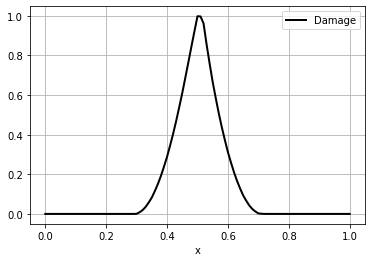

In [23]:
from utils import evaluate_on_points
tol = 0.001 # Avoid hitting the outside of the domain
y = np.linspace(0 + tol, L - tol, 101)
points = np.zeros((3, 101))
points[0] = y
points[1] = H/2


fig = plt.figure()
points_on_proc, alpha_val = evaluate_on_points(alpha, points)
plt.plot(points_on_proc[:,0], alpha_val, "k", linewidth=2, label="Damage")
plt.grid(True)
plt.xlabel("x")
plt.legend()

# If run in parallel as a python file, we save a plot per processor
plt.savefig(f"output/damage_line_rank{MPI.COMM_WORLD.rank:d}.png")

## Exercises

- Replace the mesh with an unstructured mesh generated with gmsh
- Refactor `alternate_minimization` as an external function or class to put in a seperate `.py` file to import in the notebook
- Run simulations for
    1. A slab with an hole in the center
    2. A slab with a V-notch